<div class="alert alert-success">
    <h1 align="center">Lesson 01: Image Classification (Cats vs Dogs)</h1>
    <h3 align="center"><a href="http://www.snrazavi.ir">Seyed Naser RAZAVI</a></h3>
</div>

<h6 align='center'>Kaggle competition: [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)</h6>

<img src='imgs/catsanddogs.png' width='90%'/>

## Objectives

- Image classification
- Four key components of any ML system (in PyTorch):
 - Data (Images)
 - Model (CNN)
 - Loss (Cross Entropy)
 - Optimization (SGD, Adam, ..)
- Convolutional Neural Networks (CNNs)
- Overfit
- Data augmentation
- Transfer learning

## Image Classification

<img src='imgs/Image_tasks.jpg' width='80%'/>

## Libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Our libraries
# from train import train_model
from model_utils import *
# from predict_utils import *
# from vis_utils import *

# some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

In [2]:
use_gpu

False

## Data

- train: learning the **parameters** of the model.
- valid: learning **hyper-parameters**.
- test
- development

In [3]:
# DATA_DIR = '../dataset/PetImages/dev/'
DATA_DIR = '../dataset/plant/dev/'
sz = 224
batch_size = 16

In [4]:
os.listdir(DATA_DIR)

['train', 'valid']

In [5]:
trn_dir = f'{DATA_DIR}train'
val_dir = f'{DATA_DIR}valid'

In [6]:
os.listdir(trn_dir)

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [8]:
trn_fnames = glob.glob(f'{trn_dir}/*/*.png')
trn_fnames[:5]

['../dataset/plant/dev/train\\Black-grass\\0050f38b3.png',
 '../dataset/plant/dev/train\\Black-grass\\05eedce4d.png',
 '../dataset/plant/dev/train\\Black-grass\\075d004bc.png',
 '../dataset/plant/dev/train\\Black-grass\\078eae073.png',
 '../dataset/plant/dev/train\\Black-grass\\0ace21089.png']

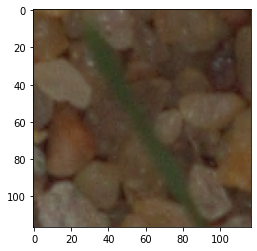

In [9]:
img = plt.imread(trn_fnames[1])
plt.imshow(img);

### Datasets and Dataloaders in PyTorch

- <h6>Dataset</h6>A set of images.
- <h6>Dataloader</h6>Loads data from dataset behind the scene using concurrent threads.

In [10]:
train_ds = datasets.ImageFolder(trn_dir)

In [11]:
train_ds.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [12]:
train_ds.class_to_idx

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

In [13]:
train_ds.root

'../dataset/plant/dev/train'

In [14]:
train_ds.imgs

[('../dataset/plant/dev/train\\Black-grass\\0050f38b3.png', 0),
 ('../dataset/plant/dev/train\\Black-grass\\05eedce4d.png', 0),
 ('../dataset/plant/dev/train\\Black-grass\\075d004bc.png', 0),
 ('../dataset/plant/dev/train\\Black-grass\\078eae073.png', 0),
 ('../dataset/plant/dev/train\\Black-grass\\0ace21089.png', 0),
 ('../dataset/plant/dev/train\\Black-grass\\0b228a6b8.png', 0),
 ('../dataset/plant/dev/train\\Black-grass\\0b3e7a7a9.png', 0),
 ('../dataset/plant/dev/train\\Black-grass\\0bb75ded8.png', 0),
 ('../dataset/plant/dev/train\\Black-grass\\0be707615.png', 0),
 ('../dataset/plant/dev/train\\Black-grass\\0c67c3fc3.png', 0),
 ('../dataset/plant/dev/train\\Black-grass\\0d1a9985f.png', 0),
 ('../dataset/plant/dev/train\\Black-grass\\0d28c429b.png', 0),
 ('../dataset/plant/dev/train\\Black-grass\\0d4f74f4a.png', 0),
 ('../dataset/plant/dev/train\\Black-grass\\0dad57e7f.png', 0),
 ('../dataset/plant/dev/train\\Black-grass\\0e91f92a1.png', 0),
 ('../dataset/plant/dev/train\\Black-gra

In [ ]:
# list(zip(*train_ds.imgs))

In [15]:
type(train_ds.transform)

NoneType

### Transformations

Dataloader object uses these tranformations when loading data.

In [16]:
tfms = transforms.Compose([
    transforms.Resize((sz, sz)),  # PIL Image
    transforms.ToTensor(),        # Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(trn_dir, transform=tfms)
valid_ds = datasets.ImageFolder(val_dir, transform=tfms)

In [17]:
len(train_ds), len(valid_ds)

(1200, 240)

#### Dataloaders

In [18]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,shuffle=True, num_workers=2)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size,shuffle=True, num_workers=2)

In [19]:
def imshow(inp, title=None):
    """Imshow for Tensor.
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)

torch.Size([3, 457, 1819])


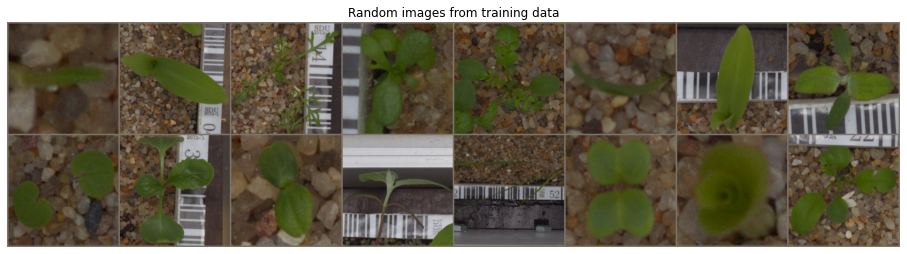

In [20]:
inputs, targets = next(iter(train_dl))

out = torchvision.utils.make_grid(inputs, padding=3)
print(out.shape)
plt.figure(figsize=(16, 12))
imshow(out, title='Random images from training data')

In [21]:
#??imshow

## Model: CNN

<img src='imgs/DogAndCats-CNN.jpg' width='100%'/>

In [22]:
class SimpleCNN(nn.Module):
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        #self.fc = nn.Linear(56 * 56 * 32, 2)
        self.fc = nn.Linear(56 * 56 * 32, 12)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)            # (bs, C, H,  W)
        out = out.view(out.size(0), -1)  # (bs, C * H, W)
        out = self.fc(out)
        return out

Now, it's time to create the model and to put it on the GPU.

In [23]:
model = SimpleCNN()

# transfer model to GPU
if use_gpu:
    model = model.cuda()

In [24]:
model

SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=100352, out_features=12, bias=True)
)

## Loss function and optimizer

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

## Train

In [26]:
def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, volatile=volatile)

In [27]:
num_epochs = 3
losses = []
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dl):
#         inputs = to_var(inputs)
#         targets = to_var(targets)
        
        # forwad pass
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # loss
        loss = criterion(outputs, targets)
        #print(loss.data.item())
#         losses += [loss.data[0]]
        losses += [loss.data.item()]
        # backward pass
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss.data.item()))

C:\Users\Pc\anaconda3\envs\tensor\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [ 1/ 3], Step [ 50/ 75], Loss: 1.9375
Epoch [ 2/ 3], Step [ 50/ 75], Loss: 1.7357
Epoch [ 3/ 3], Step [ 50/ 75], Loss: 1.0792


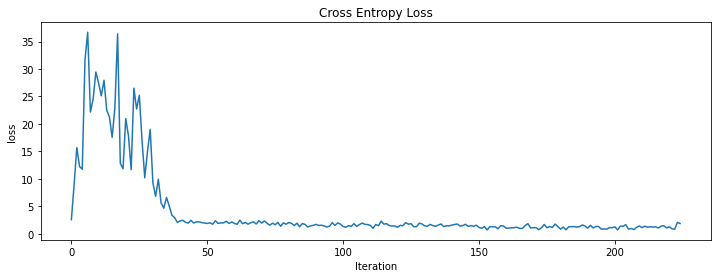

In [28]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss');

### Analyze results

#### Accuracy on validation data

In [29]:
def evaluate_model(model, dataloader):
    model.eval()  # for batch normalization layers
    corrects = 0
    for inputs, targets in dataloader:
        inputs, targets = to_var(inputs, True), to_var(targets, True)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [30]:
evaluate_model(model, valid_dl)

C:\Users\Pc\anaconda3\envs\tensor\lib\site-packages\ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.


accuracy: 50.00


In [31]:
evaluate_model(model, train_dl)

C:\Users\Pc\anaconda3\envs\tensor\lib\site-packages\ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.


accuracy: 68.42


In [32]:
def imshow(inp, title=None):
    """Imshow for Tensor.
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)

def visualize_model(model, dataloader, num_images=6):
    """ Visulaize the prediction of the model on a bunch of random data.
    """
    model.train(False)
    
    images_so_far = 0
    fig = plt.figure(figsize=(10., 8.))

    for i, (inputs, labels) in enumerate(dataloader):
        inputs, labels = to_var(inputs, volatile=True), to_var(labels, volatile=True)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(dataloader.dataset.classes[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

def plot_errors(model, dataloader):
    model.train(False)
    
    plt.figure(figsize=(12, 24))
    count = 0
    
    for inputs, labels in tqdm(dataloader):
        inputs, labels = to_var(inputs, volatile=True), to_var(labels, volatile=True)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        incorrect_idxs = np.flatnonzero(preds.cpu().numpy() != labels.data.cpu().numpy())
        
        for idx in incorrect_idxs:
            count += 1
            if count > 30: break
            ax = plt.subplot(10, 3, count)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(dataloader.dataset.classes[preds[idx]]))
            imshow(inputs.cpu().data[idx])
    plt.show()

    print("{} images out of {} were misclassified.".format(count, len(dataloader.dataset)))


C:\Users\Pc\anaconda3\envs\tensor\lib\site-packages\ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.


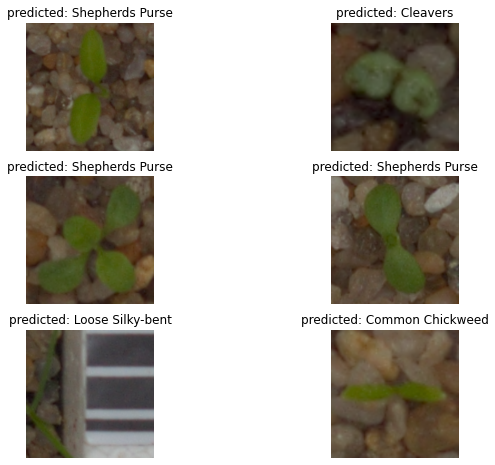

In [33]:
visualize_model(model, train_dl)

C:\Users\Pc\anaconda3\envs\tensor\lib\site-packages\ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.


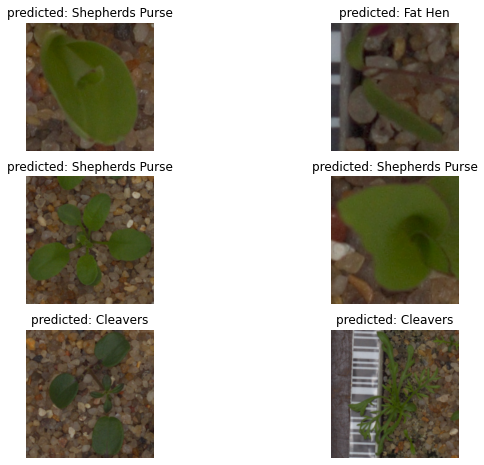

In [34]:
visualize_model(model, valid_dl)

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]C:\Users\Pc\anaconda3\envs\tensor\lib\site-packages\ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.
100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.37it/s]


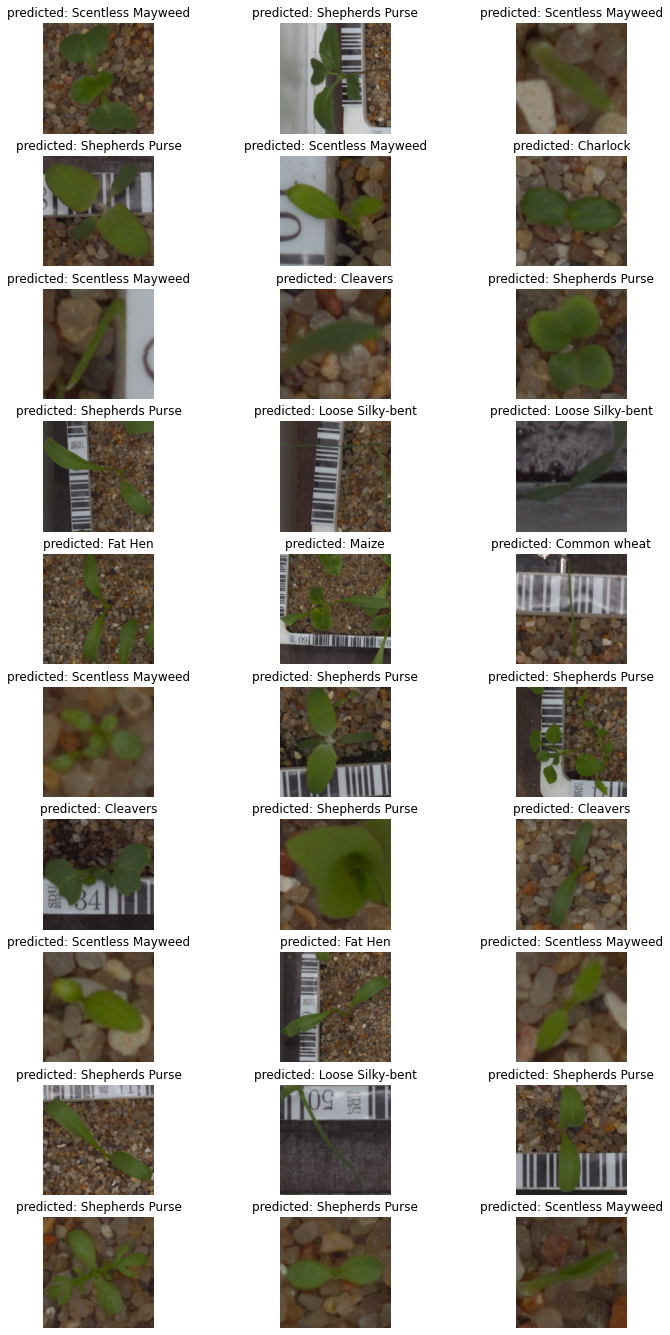

41 images out of 240 were misclassified.


In [35]:
plot_errors(model, valid_dl)

#### Confusion matrix

In [36]:
def predict_class(model, dataloader):
    """ Predict probabilities for the given model and dataset
    """
    model.train(False)
    result = []
    y = []
    
    for inputs, targets in tqdm(dataloader):
        inputs = to_var(inputs, volatile=True)
        scores = model(inputs)
        _, preds = torch.max(scores.data, 1)
        result += [preds.cpu().numpy()]
        y += [targets.cpu().numpy()]
        
    result = np.concatenate(result)
    y = np.concatenate(y)
    return result, y

In [37]:
import itertools

In [42]:
def plot_confusion_matrix(cm, classes, normalize=False, figsize=(12, 12), title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
#     plt.figure(figsize=figsize)
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        annot = "%.2f" % cm[i, j] if cm[i, j] > 0 else "" 
        plt.text(j, i, annot, horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]C:\Users\Pc\anaconda3\envs\tensor\lib\site-packages\ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.
100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.41it/s]


[[0.1  0.   0.05 0.   0.2  0.   0.65 0.   0.   0.   0.   0.  ]
 [0.   0.55 0.2  0.   0.   0.   0.   0.   0.05 0.2  0.   0.  ]
 [0.   0.05 0.85 0.   0.   0.   0.   0.05 0.05 0.   0.   0.  ]
 [0.   0.   0.   0.2  0.   0.   0.   0.2  0.3  0.3  0.   0.  ]
 [0.05 0.   0.25 0.   0.4  0.   0.05 0.   0.25 0.   0.   0.  ]
 [0.   0.   0.25 0.   0.05 0.35 0.05 0.   0.   0.25 0.05 0.  ]
 [0.1  0.   0.   0.   0.15 0.   0.6  0.   0.1  0.   0.05 0.  ]
 [0.   0.   0.   0.05 0.   0.   0.   0.65 0.1  0.2  0.   0.  ]
 [0.   0.1  0.05 0.   0.   0.1  0.   0.   0.55 0.2  0.   0.  ]
 [0.   0.   0.05 0.   0.   0.   0.   0.   0.25 0.7  0.   0.  ]
 [0.   0.05 0.   0.   0.   0.   0.   0.   0.   0.2  0.75 0.  ]
 [0.   0.   0.1  0.05 0.   0.2  0.05 0.05 0.05 0.2  0.   0.3 ]]


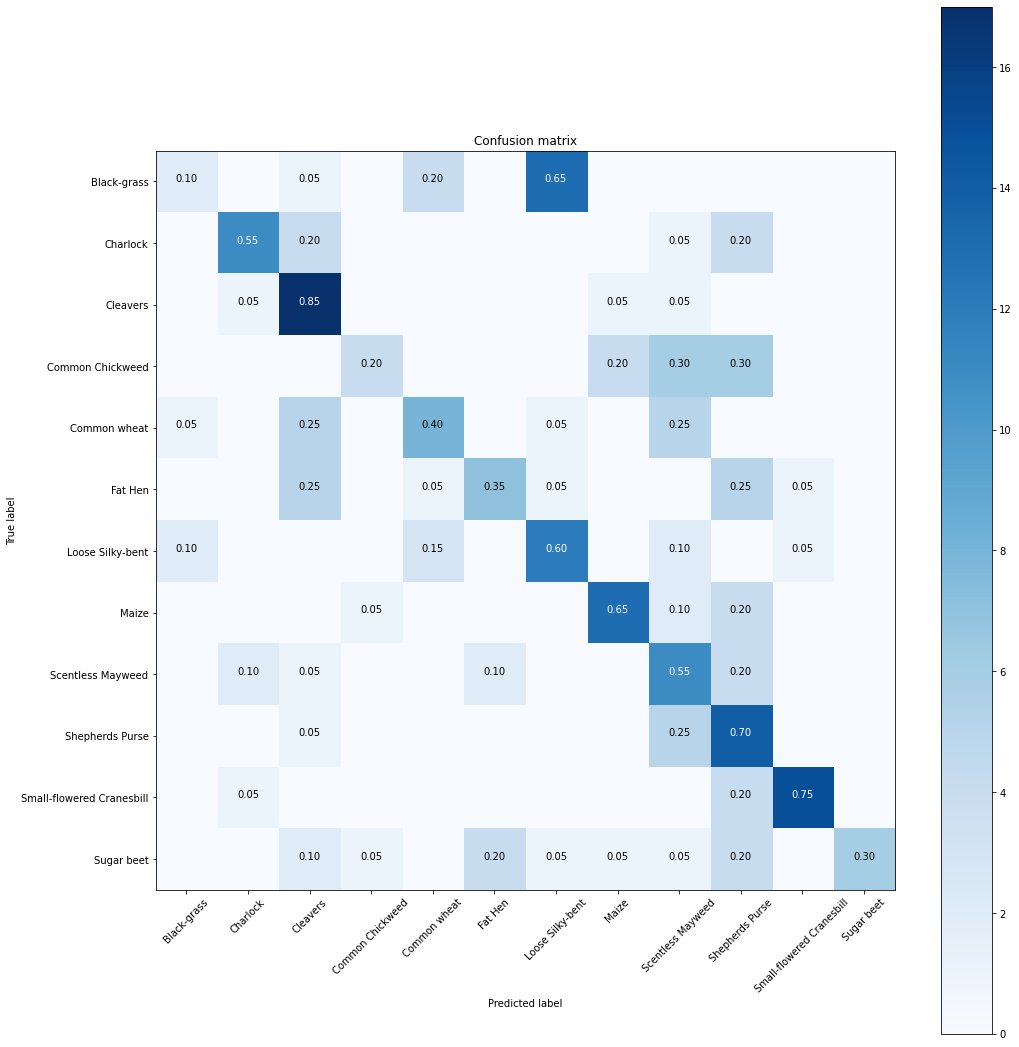

In [43]:
y_pred, y_true = predict_class(model, valid_dl)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(4, 4))

## Overfit

<div class="alert alert-success">
    <strong>What is OVERFIT? </strong>
    <ul>
        <li>The most important concept in ML!</li>
        <li>Simply, it means that your model is too complex for your problem.</li>
    </ul>
</div>

<h6>What we can do about it?</h6>

- Regularization
- Dropout
- Data Augmentation
- Transfer Learning

## Data Augmentation

<img src='imgs/Augmentation.jpg' width='90%'/>

<h6>Possible Transformations:</h6>
- Scaling
- Rotation
- Translation
- Flip horizontaly
- Random Crop
- Color jitter
- many more!

<img src='imgs/Augmentation-Examples.jpg' width='75%'/>

In [ ]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Just normalization for validation
valid_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f'{DATA_DIR}train', train_transforms)
valid_ds = datasets.ImageFolder(f'{DATA_DIR}valid', valid_transforms)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

train_ds_sz = len(train_ds)
valid_ds_sz = len(valid_ds)

print('Train size: {}\nValid size: {} ({:.2f})'.format(train_ds_sz, valid_ds_sz, valid_ds_sz/(train_ds_sz + valid_ds_sz)))

class_names = train_ds.classes

In [ ]:
inputs, targets = next(iter(train_dl))     # Get a batch of training data
out = torchvision.utils.make_grid(inputs)  # Make a grid from batch
plt.figure(figsize=(16., 12.))
imshow(out, title='Augmented Images');

#### Look at the sizes of the images

In [ ]:
fnames = glob.glob(f'{trn_dir}/*/*.jpg')
sizes = [Image.open(f).size for f in fnames]

hs, ws = list(zip(*sizes))

plt.figure(figsize=(12., 4.))
plt.hist(hs)
plt.hist(ws);

In [ ]:
# create model
model = SimpleCNN()
if use_gpu:
    model = model.cuda()
    
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

# train
model = train_model(model, train_dl, valid_dl, criterion, optimizer, num_epochs=5)

## Transfer Learning

- Use a CNN already trained on different data (e.g., [ImageNet](http://www.image-net.org/))
- Just Train the classifier weights (Last Layer)

<img src='imgs/transfer-learning.jpg' width='80%'/>

In [ ]:
# load pre-trained ResNet18
model = load_pretrained_resnet50(model_path=None, num_classes=2)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [ ]:
model = train_model(model, train_dl, valid_dl, criterion, optimizer, scheduler, num_epochs=2)

In [ ]:
evaluate_model(model, valid_dl)

In [ ]:
visualize_model(model, valid_dl, num_images=6)

In [ ]:
plot_errors(model, valid_dl)

## PROGRAMMING ASSIGNMENT 1

<div class="alert alert-success">
    <strong>[Plant Seeldlings Competition](https://www.kaggle.com/c/plant-seedlings-classification)</strong>
    <img src='imgs/PlantSeedling.png'/>
    <ul>
        <li><strong>Objective:</strong> getting a rank among top 50% in LB.</li>
        <li><strong>Ideas:</strong> different augmentations, different architectures, etc.</li>
        <li><strong>Important:</strong> share your ideas and progress on Piazz.</li>
    </ul>
</div>